# Project 02 Group 17
### *Ada's 3 table version*

## Part 1 - Requirements

The city is going to launch a new bike sharing system. Your task is to design a relational database to support its operation. The bike sharing system works as follows:

1. Riders can buy annual, semiannual or monthly membership. We need to have a record of each member's name and address in order to send them a key. Keys can be used to check out bikes at any bike station. Members have the option to renew their memberships before they expire. A member becomes inactive when his or her membership expires, therefore we need to know when their memberships expire. 

1. Each bike station has a pubic name (i.e. "18th & C St NW"). Occasionally in response to public requests, stations can be renamed. Each bike station have been built with a number of docking points.

1. Each bike is either serviceable or disabled. If it is disabled, it is removed from the station for repair.

1. For simplicity's sake, each serviceable bike is either docked at a station or checked out by a member. If it is checked out by a member, the system needs to know who has checked it out and when.

Your database should minimally support the above requirements.

## Part 2 - Designing a Database Schema (35 points)

Based on what you read above, design a relational database schema consisting of *at least* 3 tables. Document your schema with a schema diagram.  There are several tools available for this, such as [Google Drawings](https://docs.google.com/drawings/) and Microsoft Visio. Make sure to include the schema diagram in your submission. Embed and display the diagram in your notebook. Discuss your major design decisions. Be aware that your schema is designed to support transaction processing and should be optimized for writes and data consistency.

We are looking for the following when grade this part of the project:

* All required attributes are recorded.
* In the schema diagram, all primary keys are underlined. Directed lines are drawn from the foreign keys to the primary keys.
* Your database schema should be designed to promite data consistency and integrity and reduce the duplication of data. Strive for 3NF.
* Your database schema should be designed to support the requirements described in Part 1, as well as problems in Part 4 and 5.
* Key design decisions are discussed and documented in Markdown cells.

See slide 23 of week-04 lecture for an example of schema diagram. 

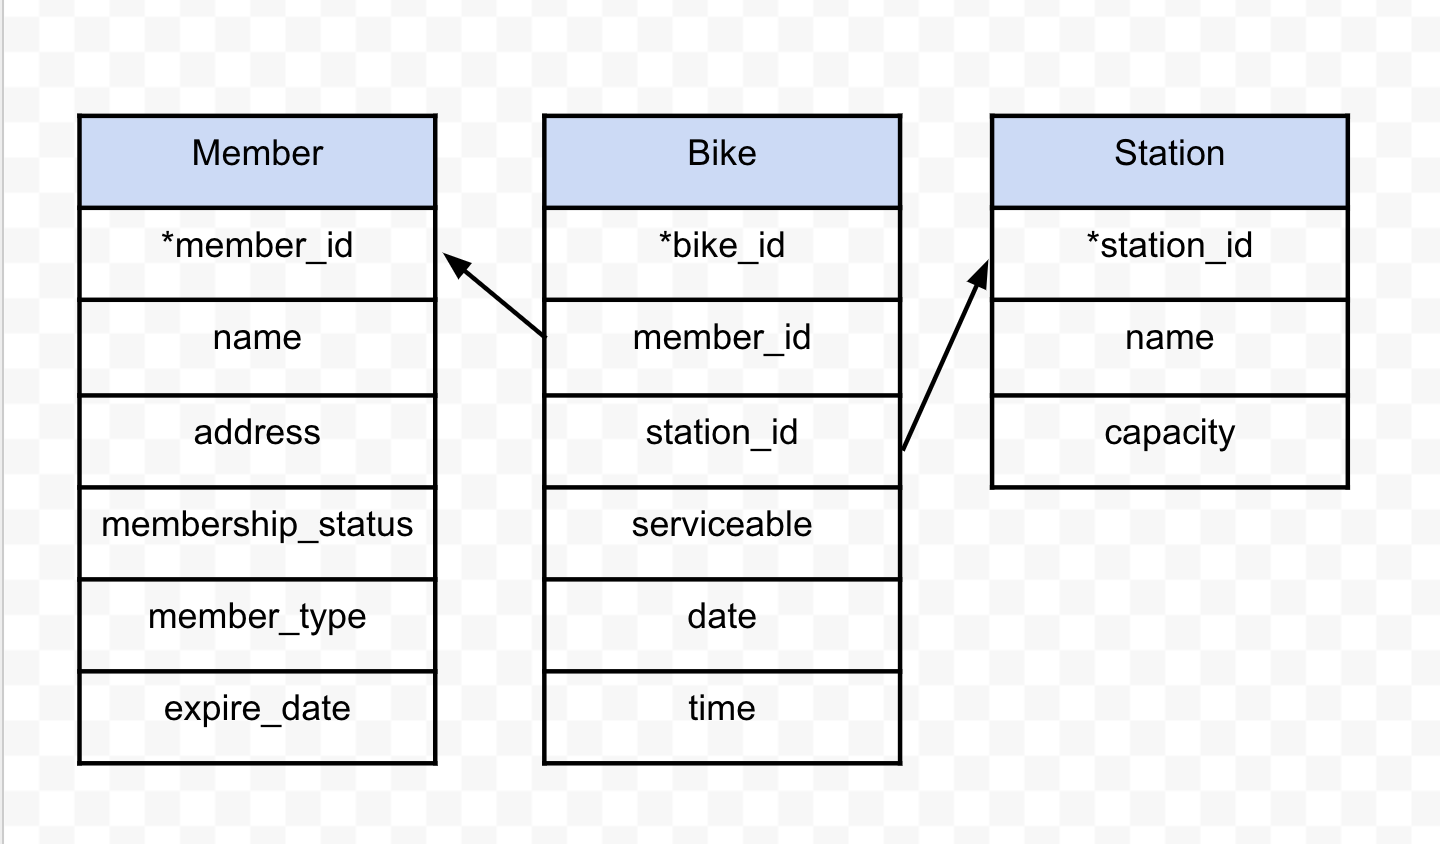

In [79]:
from IPython.display import Image
Image(filename = "diagram.png")

* Member table: primary key (member_id), attributes(name, address, membership_status, member_type, expire_date)
* Bike table: primary key (bike_id), two foreign keys(member_id, station_id), attributes (serviceable, date, time)
* Station table: primary key(station_id), attributes (name, capacity)

## Part 3 - ETL (30 points)
Please use markdown cells to **document major steps**. Use SQL queries and markdown cells to demonstrate that records are created or updated successfully.

### Problem 3.1
Examine the data located at https://s3.amazonaws.com/dmfa-2017/bike_stations.csv.
Create and connect to a new PostgreSQL database named `proj2`. Use SQL DDL to create your tables in it based on the database schema you designed in Part 2 and the data. Don't forget about the contraints (primary keys, foreign keys, proper attribute types, NOT NULL etc).

First, drop the database named `proj2` if it exists. It is necessary so that we can run this notebook repeatedly. If you get the error that says "database proj2 does not exist", that is fine. However if it complains that "There is 1 other session using the database", please restart the Kernel and try it again.

In [1]:
!dropdb -U student proj2

dropdb: database removal failed: ERROR:  database "proj2" does not exist


In [2]:
!createdb -U student proj2

In [3]:
%load_ext sql

In [4]:
%sql postgresql://student@/proj2

'Connected: student@proj2'

#### Create member relationship

In [25]:
%%sql
DROP TABLE IF EXISTS member;

CREATE TABLE member (
    member_id INTEGER PRIMARY KEY NOT NULL,
    name VARCHAR(20) NOT NULL,
    address VARCHAR(80) NOT NULL,
    membership_status BOOLEAN NOT NULL,
    member_type VARCHAR(10) NOT NULL,
    expire_date DATE NOT NULL
);

 * postgresql://student@/proj2
Done.
Done.


[]

#### Create station relationship

In [42]:
%%sql
DROP TABLE IF EXISTS station;

CREATE TABLE station (
    station_id INTEGER PRIMARY KEY NOT NULL,
    name VARCHAR(80) UNIQUE NOT NULL,
    capacity INTEGER NOT NULL
);

 * postgresql://student@/proj2
Done.
Done.


[]

#### Create bike relationship

In [43]:
%%sql
DROP TABLE IF EXISTS bike;

CREATE TABLE bike (
    bike_id VARCHAR(10) PRIMARY KEY,
    member_id INTEGER,
    station_id INTEGER,
    serviceable BOOLEAN,
    date DATE,
    time TIME,
    FOREIGN KEY (member_id)
        REFERENCES member(member_id),
    FOREIGN KEY (station_id)
        REFERENCES station(station_id)
);

 * postgresql://student@/proj2
Done.
Done.


[]

#### Check the tables

In [28]:
%sql select * from member;

 * postgresql://student@/proj2
0 rows affected.


member_id,name,address,membership_status,member_type,expire_date


In [29]:
%sql select * from station;

 * postgresql://student@/proj2
0 rows affected.


station_id,name,capacity


In [30]:
%sql select * from bike;

 * postgresql://student@/proj2
0 rows affected.


bike_id,member_id,station_id,serviceable,date,time


### Problem 3.2
Use the data located at https://s3.amazonaws.com/dmfa-2017/bike_stations.csv to populate your database. You may import the CSV file content into a temporary table in your database `proj2`. Just remember to remove it after you are done. 

Since the data doesn't include information about members, you will need to make up a few (4 or 5) members in your database. Some of their memberships have expired.

#### Create temporary table

In [44]:
%%sql
DROP TABLE IF EXISTS temp;

CREATE TABLE temp (
    bike_number     CHAR(6),
    bike_serviceable BOOLEAN,
    station_number   INTEGER,
    station_name     VARCHAR(80),
    station_capacity INTEGER
);

 * postgresql://student@/proj2
Done.
Done.


[]

In [45]:
%sql select * from temp;

 * postgresql://student@/proj2
0 rows affected.


bike_number,bike_serviceable,station_number,station_name,station_capacity


#### Download csv and import into temp table

In [33]:
!wget https://s3.amazonaws.com/dmfa-2017/bike_stations.csv

--2018-10-12 15:45:06--  https://s3.amazonaws.com/dmfa-2017/bike_stations.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.120.42
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.120.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169879 (166K) [text/csv]
Saving to: ‘bike_stations.csv’

bike_stations.csv   100%[===================>] 165.90K  --.-KB/s    in 0.003s  

2018-10-12 15:45:06 (62.4 MB/s) - ‘bike_stations.csv’ saved [169879/169879]



In [34]:
!pwd

/home/ubuntu/project2


In [46]:
%%sql
COPY temp FROM '/home/ubuntu/project2/bike_stations.csv'
CSV
HEADER;

 * postgresql://student@/proj2
4317 rows affected.


[]

In [47]:
%sql select COUNT(*) from temp;

 * postgresql://student@/proj2
1 rows affected.


count
4317


#### Insert into station relationship

In [48]:
%%sql
INSERT INTO station
SELECT DISTINCT station_number,station_name,station_capacity
FROM temp
WHERE station_number IS NOT NULL;

 * postgresql://student@/proj2
452 rows affected.


[]

#### Insert into bike relationship

In [49]:
%%sql
INSERT INTO bike(bike_id, station_id, serviceable)
SELECT bike_number,station_number,bike_serviceable
FROM temp
WHERE bike_number IS NOT NULL;

 * postgresql://student@/proj2
4298 rows affected.


[]

#### Insert into member relationship

In [53]:
%%sql
DELETE FROM member;
INSERT INTO member
VALUES ('1','Amy','1 St',TRUE,'annual','2018-10-01');
INSERT INTO member
VALUES ('2','Bob','2 St',TRUE,'semiannual','2018-10-02');
INSERT INTO member
VALUES ('3','Carl','3 St',FALSE,'monthly','2018-10-03');
INSERT INTO member
VALUES ('4','Dan','4 St',TRUE,'annual','2018-10-04');
INSERT INTO member
VALUES ('5','Eden','5 St',TRUE,'annual','2018-10-05');

 * postgresql://student@/proj2
5 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


[]

In [54]:
%%sql
SELECT * FROM member;

 * postgresql://student@/proj2
5 rows affected.


member_id,name,address,membership_status,member_type,expire_date
1,Amy,1 St,True,annual,2018-10-01
2,Bob,2 St,True,semiannual,2018-10-02
3,Carl,3 St,False,monthly,2018-10-03
4,Dan,4 St,True,annual,2018-10-04
5,Eden,5 St,True,annual,2018-10-05


Delete temp table

In [55]:
%%sql
DROP TABLE temp;

 * postgresql://student@/proj2
Done.


[]

## Part 4 - Operations (15 points)
Use SQL queries and markdown cells to demonstrate that records are created or updated successfully.

### Problem 4.1
The bike 'W20131' is having mechanical problems and needs to be repaired off-site. Use SQL UPDATE statements to record the fact that this bike is no longer serviceable and has been removed from the station where it was docked at.

#### Change serviceable and station_id in bike

In [56]:
%%sql
START TRANSACTION;

UPDATE bike 
SET serviceable = FALSE
WHERE bike_id = 'W20131';

UPDATE bike
SET station_id = NULL
WHERE bike_id = 'W20131';

COMMIT;

 * postgresql://student@/proj2
Done.
1 rows affected.
1 rows affected.
Done.


[]

#### Check table updates

In [57]:
%%sql
SELECT *
FROM bike
WHERE bike_id='W20131';

 * postgresql://student@/proj2
1 rows affected.


bike_id,member_id,station_id,serviceable,date,time
W20131,None,None,False,None,None


### Problem 4.2
The bike station at Adams Mill & Columbia Rd NW has been expanded. Use SQL UPDATE statements to change the name of the bike station from "Adams Mill & Columbia Rd NW" to "18th & Columbia Rd NW" and increase its capacity by 10.

In [58]:
%%sql
START TRANSACTION;
UPDATE station
SET name = '18th & Columbia Rd NW', capacity = capacity + 10 
WHERE name = 'Adams Mill & Columbia Rd NW';
COMMIT;

 * postgresql://student@/proj2
Done.
1 rows affected.
Done.


[]

#### Check update

In [59]:
%%sql
SELECT *
FROM station
WHERE name = '18th & Columbia Rd NW';

 * postgresql://student@/proj2
1 rows affected.


station_id,name,capacity
31104,18th & Columbia Rd NW,14


### Problem 4.3
Use SQL UPDATE and/or INSERT statements to record the transaction that an active member checked out the bike 'W00005' from station 'Maple & Ritchie Ave' at '2017-10-01 08:46:00'.

#### Check original data

In [60]:
%%sql
SELECT *
FROM bike, station
WHERE bike.station_id = station.station_id AND bike.bike_id = 'W00005';

 * postgresql://student@/proj2
1 rows affected.


bike_id,member_id,station_id,serviceable,date,time,station_id_1,name,capacity
W00005,None,32011,True,None,None,32011,Maple & Ritchie Ave,28


#### Update data

In [67]:
%%sql
START TRANSACTION;
UPDATE bike
SET member_id = 5, 
    station_id = NULL, 
    serviceable = TRUE, 
    date = '2017-10-01', 
    time = '08:46:00'
WHERE bike_id = 'W00005';
COMMIT;

 * postgresql://student@/proj2
Done.
1 rows affected.
Done.


[]

#### Check updated data

In [68]:
%%sql
SELECT *
FROM bike
LEFT JOIN station ON bike.station_id = station.station_id 
WHERE bike_id = 'W00005';

 * postgresql://student@/proj2
1 rows affected.


bike_id,member_id,station_id,serviceable,date,time,station_id_1,name,capacity
W00005,5,None,True,2017-10-01,08:46:00,None,None,None


## Part 5 - Queries (20 points)

Use SQL SELECT statements to answer the following questions. Use markdown cells to explain your SQL statements and results if needed.

### Problem 5.1
For all members, display their name, membership type (annual, semiannual or monthly, in readable text), membership status (active or expired, boolean value is fine) and the date when the membership expires.

In [70]:
%%sql
SELECT DISTINCT name, member_type, membership_status, expire_date
FROM member;

 * postgresql://student@/proj2
5 rows affected.


name,member_type,membership_status,expire_date
Eden,annual,True,2018-10-05
Dan,annual,True,2018-10-04
Carl,monthly,False,2018-10-03
Bob,semiannual,True,2018-10-02
Amy,annual,True,2018-10-01


### Problem 5.2
Display the first 10 bikes base on the bike number in ascending order. For each bike, list its status (serviceable or disabled, boolean value is fine), the station name where it is docked at if there is any, the member if the bike is currently checked out, and when it was checked out. Hint: you should see one disabled bike and one checked out bike.

In [73]:
%%sql
SELECT bike.bike_id,
    bike.serviceable,
    station.name,
    bike.member_id,
    member.name as member_name,
    bike.date,
    bike.time
FROM bike
LEFT JOIN station 
    ON bike.station_id = station.station_id 
LEFT JOIN member
    ON member.member_id = bike.member_id
ORDER BY bike.bike_id ASC 
LIMIT 10;

 * postgresql://student@/proj2
10 rows affected.


bike_id,serviceable,name,member_id,member_name,date,time
W00001,True,Ward Circle / American University,None,None,None,None
W00005,True,None,5,Eden,2017-10-01,08:46:00
W00007,True,Gallaudet / 8th St & Florida Ave NE,None,None,None,None
W00009,True,Mount Vernon Ave & Bruce St,None,None,None,None
W00010,True,Jefferson Memorial,None,None,None,None
W00011,False,None,None,None,None,None
W00012,True,Wilson Blvd & N Illinois St,None,None,None,None
W00013,True,Lee Center,None,None,None,None
W00014,True,Wilson Blvd & N Illinois St,None,None,None,None
W00015,True,Saint Asaph St & Pendleton St,None,None,None,None


* Select all columns related. 
* Join two tables(station, bike) by common value.
* Display in ascending order.
* Limit to 10 rows.

### Problem 5.3
Display the top 10 stations which currently have the most bikes docked. For each station, list the station name and the total number of bikes docked there.

In [74]:
%%sql
SELECT station.name, COUNT(bike.bike_id) AS total_docked
FROM station, bike
WHERE station.station_id = bike.station_id
GROUP BY station.station_id
ORDER BY total_docked DESC 
LIMIT 10;

 * postgresql://student@/proj2
10 rows affected.


name,total_docked
Columbus Circle / Union Station,49
14th & V St NW,41
2nd & G St NE,36
13th & D St NE,33
12th & U St NW,32
11th & Kenyon St NW,29
1st & N St SE,28
4th & M St SW,27
6th & H St NE,27
13th & H St NE,27


* Find bikes docked number in a station by counting rows of bike_id in bike table where its * station_id matches the one in station table.
* Select station names and count bike_id by joining two tables using station_id. 
* Group results with station_id and order by counts.
* Limit to top 10 stations names and docked numbers.

### Problem 5.4
Display the first 10 stations based on their names in ascending order. For each station, list station name and the number of available docking points accepting bike returns. Verify the numbers are correct.

In [77]:
%%sql
SELECT station.name, 
    station.capacity - COUNT(bike.bike_id) AS availability, 
    station.capacity,
    COUNT(bike.bike_id) as docked_bike
FROM station, bike
WHERE station.station_id = bike.station_id
GROUP BY station.station_id
ORDER BY station.name ASC
LIMIT 10;

 * postgresql://student@/proj2
10 rows affected.


name,availability,capacity,docked_bike
10th & E St NW,2,17,15
10th & Florida Ave NW,5,21,16
10th & G St NW,8,14,6
10th & K St NW,6,14,8
10th & Monroe St NE,2,3,1
10th St & Constitution Ave NW,5,13,8
10th St & L'Enfant Plaza SW,7,8,1
10th & U St NW,2,17,15
11th & F St NW,2,8,6
11th & H St NE,3,23,20


* Availability: subtract counts of bike_id from station capacity.
* Select station names and create availability. 
* Group results based on station_id.
* Order by station names in ascending order.